In [2]:
from multidimvis_main import *

In [51]:
################################################
#
# H U M A N 
#
################################################

organism = 'Human'

G = nx.read_edgelist('input/ppi_elist.txt',data=False)

In [52]:
#################################################################
#
#    SAMPLE SUP PPI NETWORK
#
#################################################################

rand_set = rd.sample(G.nodes(),1000)

G_sub = nx.subgraph(G,rand_set)

G_ = G_sub.subgraph(max(nx.connected_components(G_sub), key=len))  # extract lcc graph


print(G_.number_of_nodes())
print(G_.number_of_edges())

# nx.write_edgelist(G,'subPPI_4testing.txt')
G=G_

581
1224


In [66]:
diameter = nx.diameter(G)

## Diagram (network distance, spring, global layout)

In [53]:
%%time 

# SPRING LAYOUT

posG_spring2D = nx.spring_layout(G, iterations = 10, dim = 2)
df_posG = pd.DataFrame(posG_spring2D).T
x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)
posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

CPU times: user 554 ms, sys: 7.34 ms, total: 561 ms
Wall time: 567 ms


In [60]:
%%time 

# GLOBAL LAYOUT

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20
spread = 1
min_dist = 0.0
metric = 'cosine'
lnr = 1 
nep = None

feature = 'RWRvis'
r = .9 
alpha = 1.0
A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
DM_rwr = pd.DataFrame(FM_m_array).T

umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_rwr).T
x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)
posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

CPU times: user 3.66 s, sys: 821 ms, total: 4.48 s
Wall time: 4.17 s


In [61]:
posG_layout = posG_complete_umap_rwr#_norm
posG_spring = posG_spring2D #_norm

In [62]:
%%time 

dist_spring2D = {} 
dist_network2D = {}
dist_layout2D = {}
for p1,p2 in it.combinations(G.nodes(),2):
    dist_network2D[(p1,p2)] = nx.shortest_path_length(G,p1,p2)
    dist_spring2D[(p1,p2)] = np.sqrt((posG_spring[p1][0]-posG_spring[p2][0])**2 + (posG_spring[p1][1]-posG_spring[p2][1])**2)
    dist_layout2D[(p1,p2)] = np.sqrt((posG_layout[p1][0]-posG_layout[p2][0])**2+(posG_layout[p1][1]-posG_layout[p2][1])**2)

CPU times: user 48.2 s, sys: 360 ms, total: 48.5 s
Wall time: 48.9 s


In [63]:
d_plot_spring = {}
for spldist in range(1,int(max(dist_network2D.values()))+1):
    l_s = []
    for k, v in dist_network2D.items():
        if v == spldist:
            l_s.append(k)

    l_xy = []
    for nodes in l_s:
        try:
            dxy = dist_spring2D[nodes]
            l_xy.append(dxy)
        except:
            pass
    d_plot_spring[spldist] = l_xy
    
    
d_plot_layout = {}
for spldist in range(1,int(max(dist_network2D.values()))+1):
    l_s = []
    for k, v in dist_network2D.items():
        if v == spldist:
            l_s.append(k)

    l_xy = []
    for nodes in l_s:
        try:
            dxy = dist_layout2D[nodes]
            l_xy.append(dxy)
        except:
            pass
    d_plot_layout[spldist] = l_xy

## Pearson Correlation Coefficient

In [73]:
l_medians = []
for k, v in d_plot_spring.items():
    l_medians.append(statistics.median(v))
r = np.corrcoef(np.array(range(1,int(max(dist_network2D.values()))+1)), np.array(l_medians))
print('Pearson correlation coefficient:', r[0][1])

Pearson correlation coefficient: 0.9245142125516134


In [74]:
l_medians = []
for k, v in d_plot_layout.items():
    l_medians.append(statistics.median(v))
r = np.corrcoef(np.array(range(1,int(max(dist_network2D.values()))+1)), np.array(l_medians))
print('Pearson correlation coefficient:', r[0][1])

Pearson correlation coefficient: 0.9267977482372192


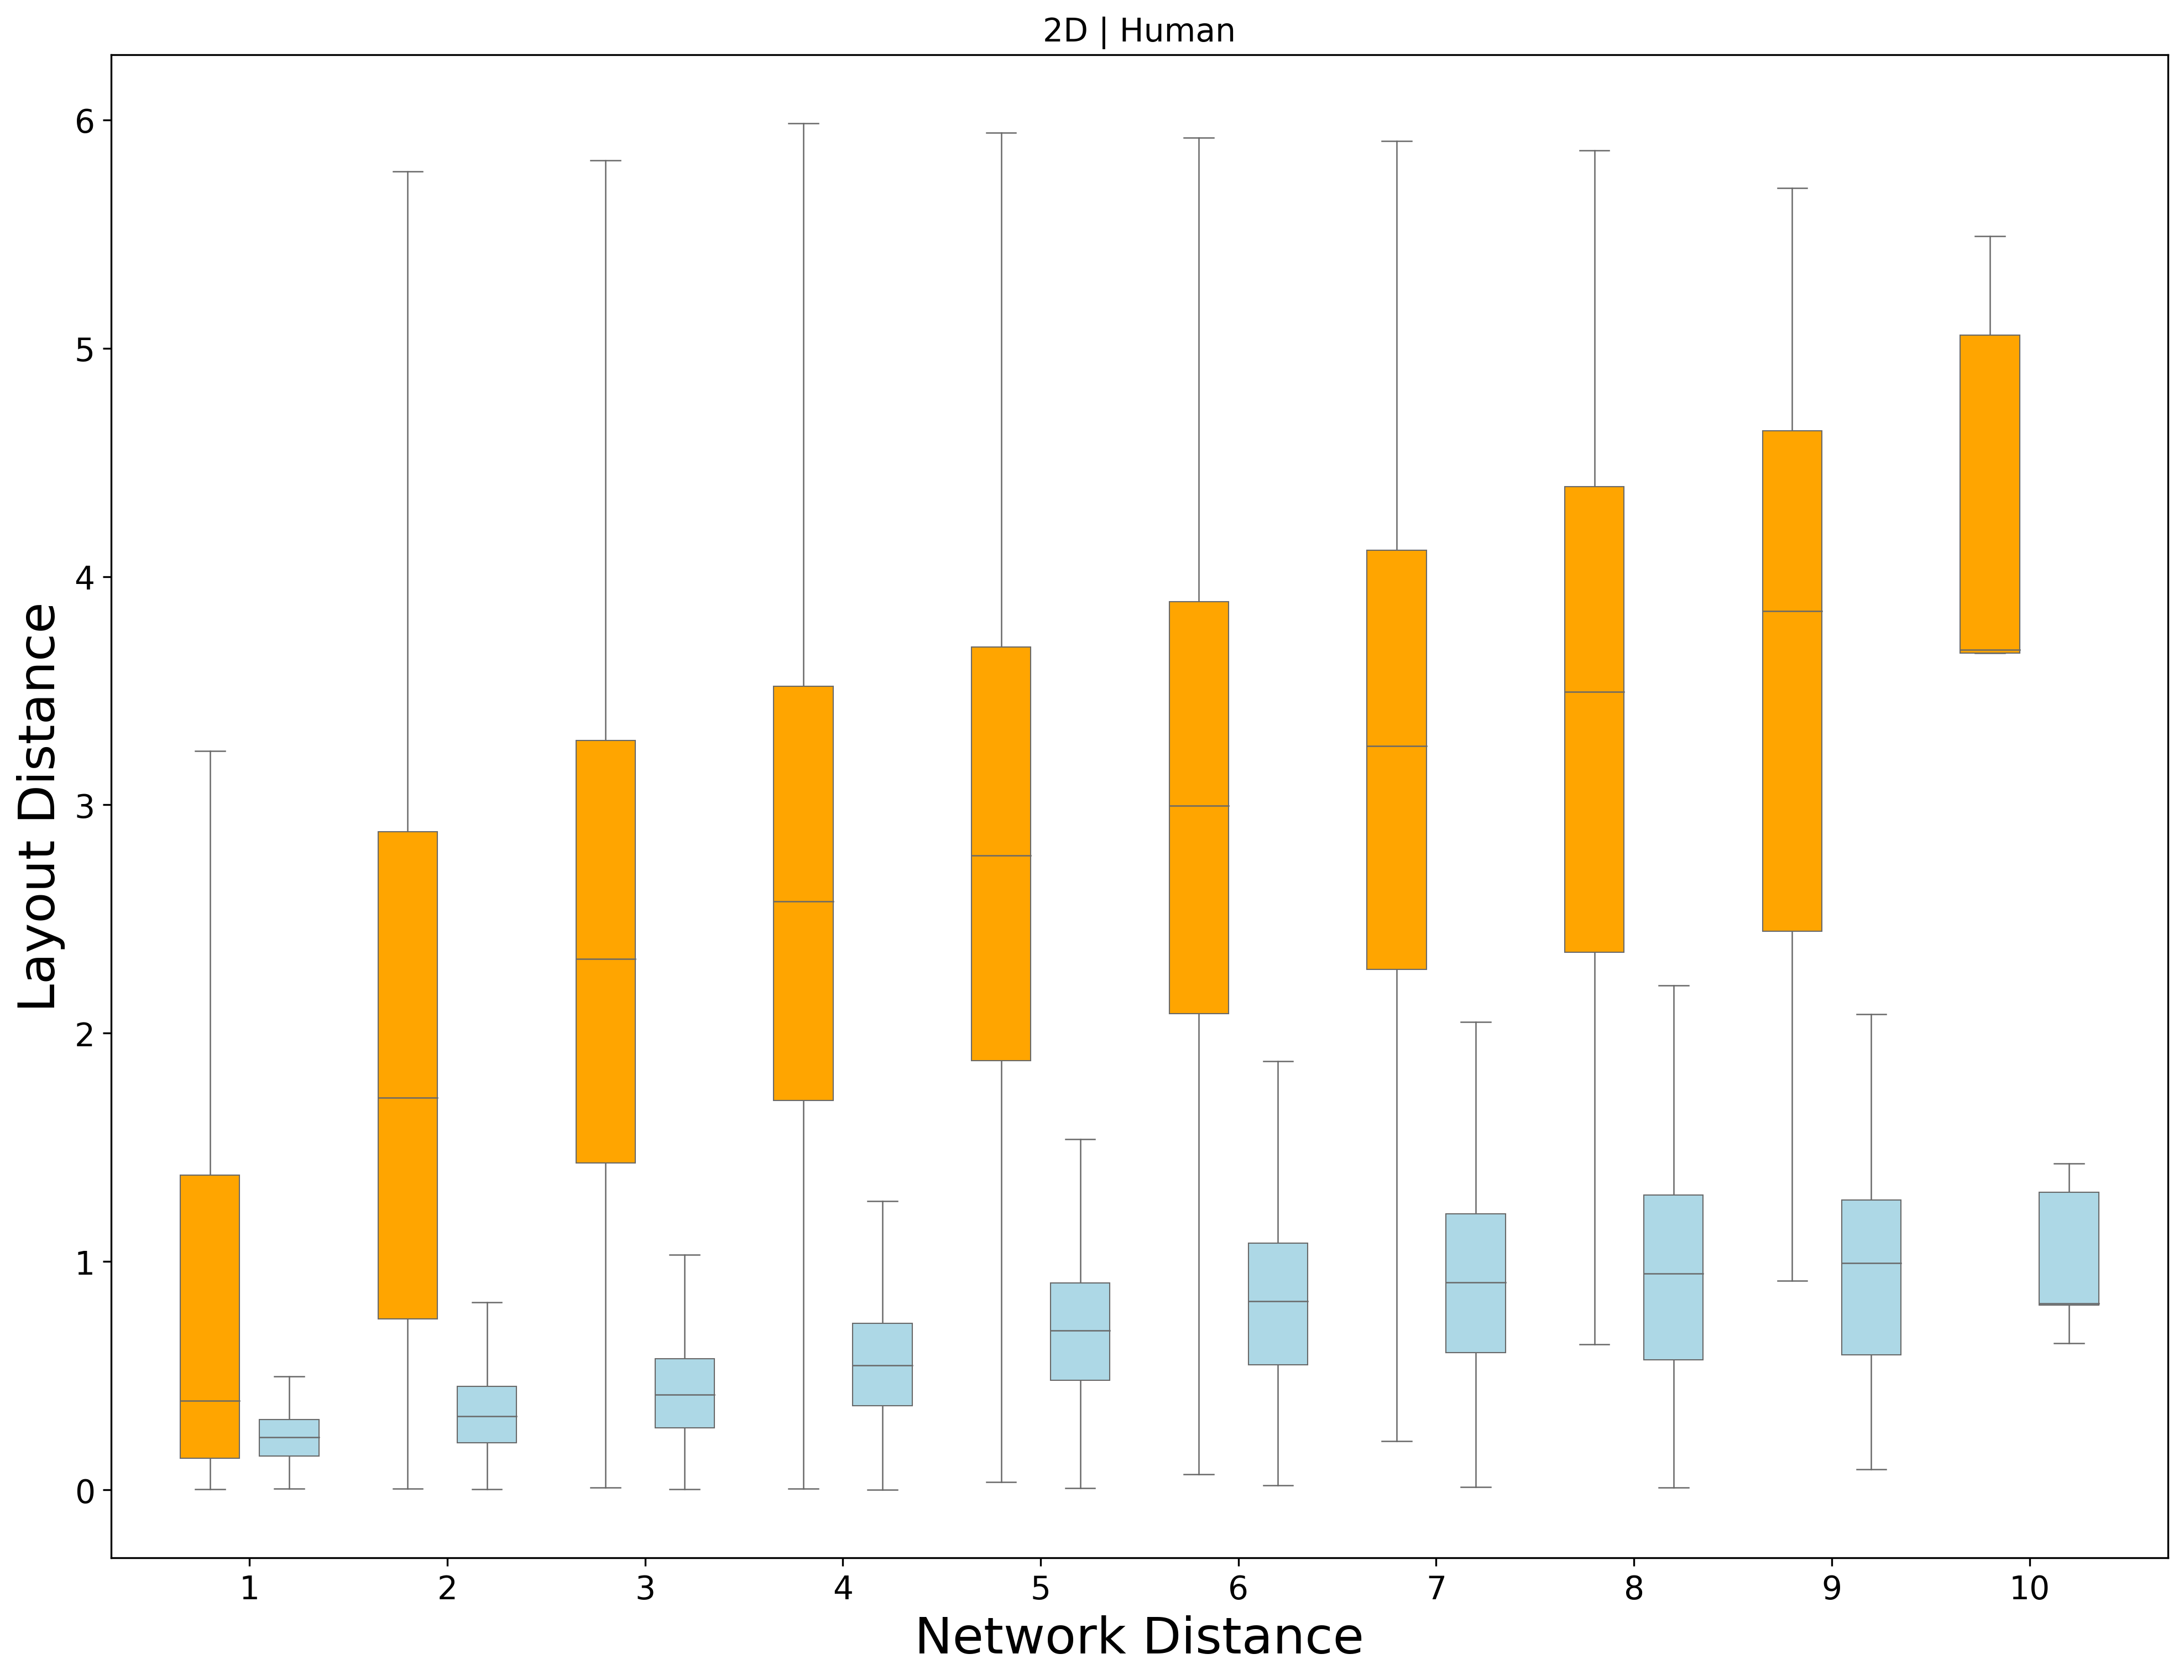

In [75]:
offset = 0.2 

fig, ax = plt.subplots(figsize =(16,12), dpi=300)
bp_spring = ax.boxplot(d_plot_spring.values(), positions=[i+offset for i in list(d_plot_spring.keys())], widths=0.3, patch_artist=True, showfliers=False)
bp_layout = ax.boxplot(d_plot_layout.values(), positions=[i-offset for i in list(d_plot_layout.keys())], widths=0.3, patch_artist=True, showfliers=False)

for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
    plt.setp(bp_spring[element], color='dimgrey', linewidth=0.6)
    plt.setp(bp_layout[element], color='dimgrey', linewidth=0.6)

for patch in bp_spring['boxes']:
    patch.set(facecolor='lightblue', linewidth=0.5)
    
for patch in bp_layout['boxes']:
    patch.set(facecolor='orange', linewidth=0.5)

plt.xlabel('Network Distance', fontsize=22)
plt.ylabel('Layout Distance', fontsize=22)

plt.xticks(range(1,len(d_plot_spring.keys())+1),d_plot_spring.keys(), fontsize=14)
plt.yticks(fontsize=14)


plt.title('2D | '+organism, fontsize=14)
#plt.suptitle('Pears corr coef: '+'\n'+'SPRING: '+str(r_spring[0][1])+'\n'+ 'GLOBAL: '+str(r_layout[0][1]), fontsize=10)

plt.show()
#fig.savefig('output_plots/benchmark/2Dtoynetwork_NetworkDistances_'+'springitr'+str(itr)+'_'+organism+'.png')

In [102]:
#################################################################
#
#    Visiting probability based distances
#
##################################################################   

In [210]:
t0 = time.time()

r = .8
alpha = 1.
num_nodes = G.number_of_nodes()
A = nx.adjacency_matrix(G,sorted(G.nodes()))

#################################################################
#
#    INVERT MARKOV MATRIX & GENERATE RW MATRIX
#
###################

W = rnd_walk_matrix(A, r, alpha, num_nodes)

print('Inversion done')

#################################################################
#
#    GENERATE DICT FOR NODE-LABELS TO INTEGERS
#
###################

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1
d_entz_idx = dict((y,x) for x,y in d_idx_entz.items())   


print('computing time: %.2f' %float(time.time()-t0))

Inversion done
computing time: 0.06


In [211]:
d_pvis = {}
for a,b in it.combinations(G.nodes(),2):
    idx_a = d_entz_idx[a]
    idx_b = d_entz_idx[b]
    # print(idx_a)
    # print()
    # print(W[idx_a,idx_b])
    p_d =  min((W[idx_a,idx_b],W[idx_b,idx_a]))
    d_pvis[(a,b)] = -np.log(p_d)


In [212]:
# l_stacked_xy = np.zeros(100)
d_violin_p = {}
for dd in range(1,diameter):
    l_s = []
    for k, v in d_spl.items():
        if v == dd:
            l_s.append(k)

    l_pvis = []
    for ab in l_s:
        try:
            dp = d_pvis[ab]
            l_pvis.append(dp)
            # print(ab,dxy)
        except:
            pass
    # l_stacked_xy = np.vstack((l_stacked_xy,l_xy))
    d_violin_p["string{0}".format(dd)] = l_pvis


Text(0, 0.5, 'distribution of -log pvis distances')

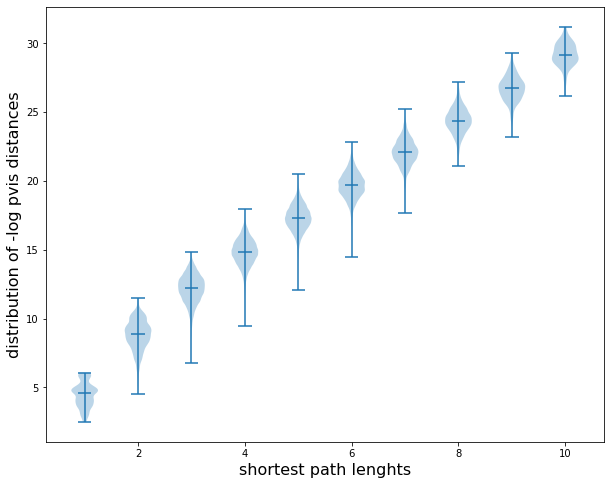

In [213]:
plt.figure(figsize=(10,8))
plt.violinplot(d_violin_p.values(), showmedians=True)
plt.xlabel('shortest path lenghts',fontsize = 16)
plt.ylabel('distribution of -log pvis distances',fontsize = 16)
# plt.savefig('spl_xy_N1000.png')


# --------------------------------------